# Libraries

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import tensorflow as tf
import seaborn as sns
import random

from keras.models import Model
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from PIL import Image

# Data

In [110]:
image_dir = Path('dataset')

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,dataset\Beagle\Beagle_1.jpg,Beagle
1,dataset\Beagle\Beagle_10.jpg,Beagle
2,dataset\Beagle\Beagle_100.jpg,Beagle
3,dataset\Beagle\Beagle_11.jpg,Beagle
4,dataset\Beagle\Beagle_12.jpg,Beagle
...,...,...
1929,dataset\Yorkshire_Terrier\Yorkshire Terrier_95...,Yorkshire_Terrier
1930,dataset\Yorkshire_Terrier\Yorkshire Terrier_96...,Yorkshire_Terrier
1931,dataset\Yorkshire_Terrier\Yorkshire Terrier_97...,Yorkshire_Terrier
1932,dataset\Yorkshire_Terrier\Yorkshire Terrier_98...,Yorkshire_Terrier


# Exploratory Data Analysis

### Image distribution

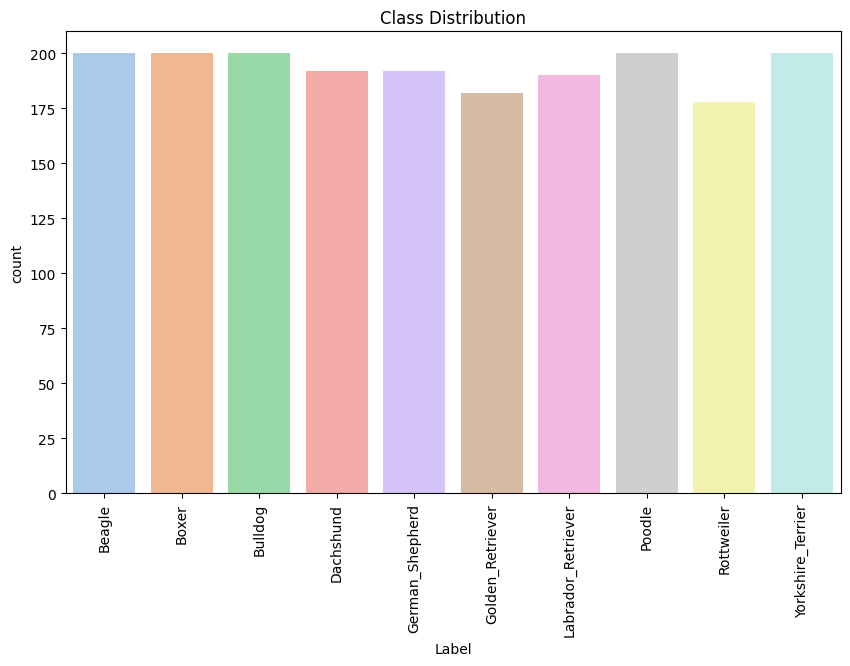

In [111]:
plt.figure(figsize = (10, 6))
plt.title('Class Distribution')
sns.countplot(data = image_df, x = 'Label', hue = 'Label', palette='pastel') 
plt.xticks(rotation = 90)
plt.show()

In [139]:
label_counts = image_df['Label'].value_counts()
label_counts

Label
Beagle                200
Boxer                 200
Bulldog               200
Poodle                200
Yorkshire_Terrier     200
Dachshund             192
German_Shepherd       192
Labrador_Retriever    190
Golden_Retriever      182
Rottweiler            178
Name: count, dtype: int64

### Images example

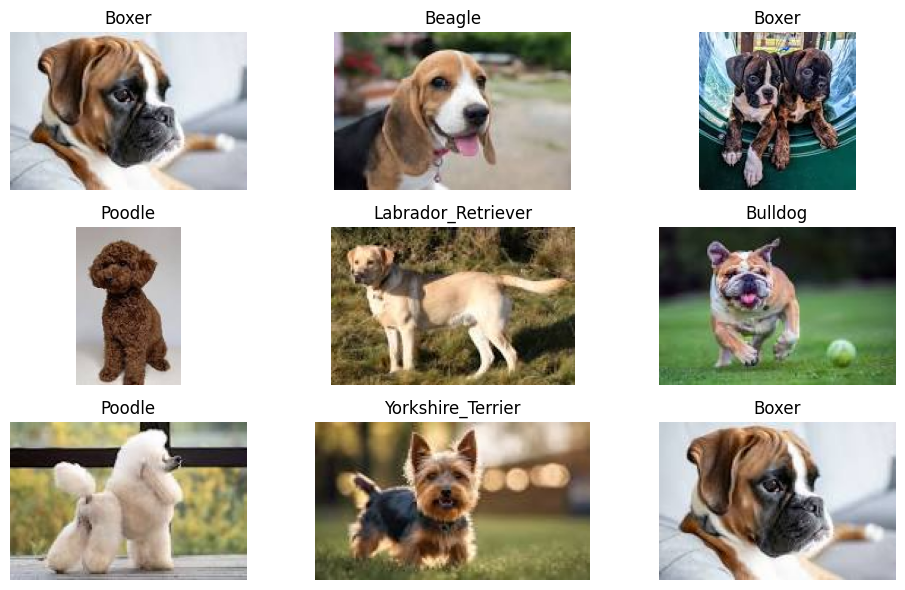

In [154]:
random_images = image_df.sample(n = 9)

fig, ax = plt.subplots(3, 3, figsize = (10, 6))
ax = ax.flatten()

for ax, (index, row) in zip(ax, random_images.iterrows()):
    img = Image.open(row["Filepath"])
    ax.imshow(img)
    ax.set_title(row["Label"])
    ax.axis("off")

plt.tight_layout()
plt.show()


# Data Pre Processing

### Converting image to array

In [113]:
def image_to_array(filepath, size = (150, 150)):
    img = Image.open(filepath).resize(size)
    return np.array(img)

X = np.array([image_to_array(filepath) for filepath in image_df['Filepath']])
y = np.array(image_df['Label'])

print(f'X shape: {X.shape}') # -> jumlah, size, size (height width), channel 3 (RGB)
print(f'y shape: {y.shape}')

X shape: (1934, 150, 150, 3)
y shape: (1934,)


In [114]:
X = X.astype('float32')
X /= 255

In [115]:
encoder = OneHotEncoder()
y = y.reshape(-1, 1)
y = encoder.fit_transform(y).toarray()

In [116]:
#Splitting Train and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Splitting Test and validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')
print('')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (1547, 150, 150, 3)
X_test shape: (193, 150, 150, 3)
X_val shape: (194, 150, 150, 3)

y_train shape: (1547, 10)
y_test shape: (193, 10)
y_val shape: (194, 10)


# Modeling

## VGG16

In [117]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = prediction)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [118]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)
validation_generator = test_datagen.flow(X_val, y_test, batch_size=32)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [119]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
49/49 [==============================] - 6s 105ms/step - loss: 2.1609 - accuracy: 0.2857 - val_loss: 1.1795 - val_accuracy: 0.7680
Epoch 2/30
49/49 [==============================] - 5s 99ms/step - loss: 1.4430 - accuracy: 0.5042 - val_loss: 0.6519 - val_accuracy: 0.8711
Epoch 3/30
49/49 [==============================] - 5s 99ms/step - loss: 1.1294 - accuracy: 0.6160 - val_loss: 0.4272 - val_accuracy: 0.9433
Epoch 4/30
49/49 [==============================] - 5s 100ms/step - loss: 0.8849 - accuracy: 0.7078 - val_loss: 0.2562 - val_accuracy: 0.9536
Epoch 5/30
49/49 [==============================] - 5s 98ms/step - loss: 0.7172 - accuracy: 0.7602 - val_loss: 0.2061 - val_accuracy: 0.9742
Epoch 6/30
49/49 [==============================] - 5s 99ms/step - loss: 0.6481 - accuracy: 0.7977 - val_loss: 0.1264 - val_accuracy: 0.9845
Epoch 7/30
49/49 [==============================] - 5s 100ms/step - loss: 0.5438 - accuracy: 0.8287 - val_loss: 0.0881 - val_accuracy: 0.9948
Epoch 8/30

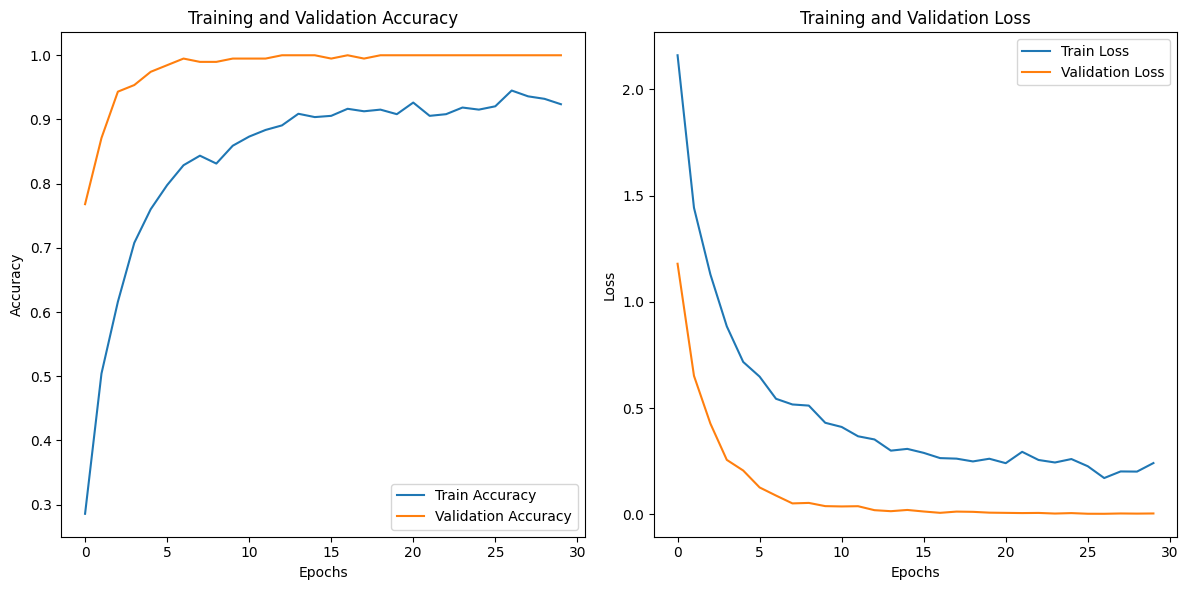

In [120]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [131]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
#y_true = test_generator.labels
print(classification_report(y_true, y_pred_classes))

7/7 [==============================] - 1s 74ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        19

    accuracy                           1.00       193
   macro avg       1.00      1.00      1.00       193
weighted avg       1.00      1.00      1.00       193



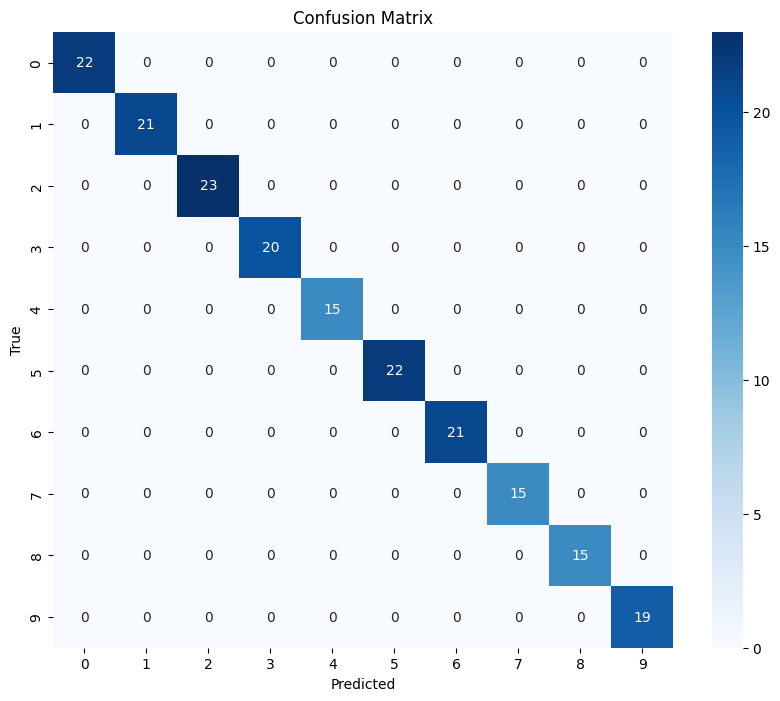

In [136]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel()

In [143]:
def plot_images_with_predictions(X, y_true, y_pred, class_names, num_images=9):
    indices = random.sample(range(len(X)), num_images)
    images = X[indices]
    true_labels = y_true[indices]
    pred_labels = y_pred[indices]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Actual: {class_names[true_labels[i]]}\nPredicted: {class_names[pred_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
class_names = label_counts.index

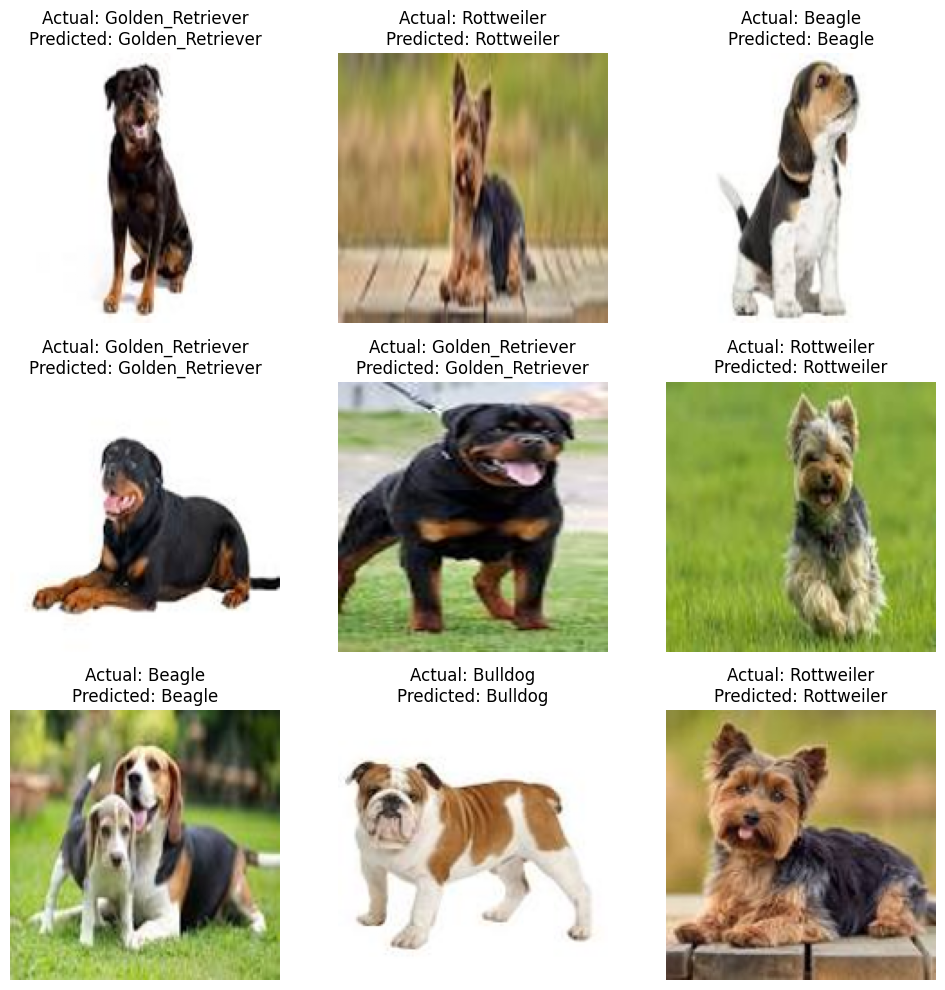

In [151]:
plot_images_with_predictions(X_test, y_true, y_pred_classes, class_names)